# **Preprocessing of the USIS10K Dataset**

The [Underwater Salient Instance Segmentation Dataset (USIS10K)](https://github.com/liamlian0727/usis10k) contains 10,632 underwater images with pixel-level annotations in seven categories of various underwater scenes. This large-scale dataset, designed for underwater salient instance segmentation, is split into 70% (7,442 images) for training, 15% (1,594 images) for validation, and 15% (1,596 images) for testing. Table 5 from the [official paper](https://raw.githubusercontent.com/mlresearch/v235/main/assets/lian24c/lian24c.pdf) lists all category labels in the USIS10K dataset along with their detailed definitions:

| Category       | Description                                                                                |
|----------------|--------------------------------------------------------------------------------------------|
| Fish           | Underwater vertebrates, e.g., fish, turtles                                                |
| Reefs          | Underwater invertebrates and coral reefs                                                   |
| Aquatic plants | Aquatic plants and flora                                                                   |
| Wrecks/ruins   | Wrecks, ruins and damaged artifacts                                                        |
| Human divers   | Human divers and their equipment                                                           |
| Robots         | Underwater robots like AUV (Autonomous Underwater Vehicle), ROV (Remotely Operated Vehicle)|
| Sea-floor      | Rocks and reefs on the seafloor                                                            |

## **Imports**

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import plotly.express as px
from PIL import Image
import pandas as pd
from google.colab import drive
from tqdm.auto import tqdm
from glob import glob
import shutil
import yaml
import json
import os

In [ ]:
# Mount Google Drive in Colab
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


## **Parameters**

In [3]:
raw_dataset_path = "/content/drive/MyDrive/Datasets/Raw_USIS10K.zip"
raw_dataset_dir = os.path.basename(raw_dataset_path).split(".")[0]
dataset_dir = "/content/USIS10K"
zip_dataset_path = "/content/drive/MyDrive/Datasets/USIS10K.zip"

## **Download and Extract Dataset**

The complete dataset is available as a ZIP file on the [official USIS10K Google Drive](https://drive.google.com/file/d/1LdjLPaieWA4m8vLV6hEeMvt5wHnLg9gV/view).

In [ ]:
# Unzip the raw dataset
!unzip -q {raw_dataset_path} -d {os.getcwd()}

os.rename(dataset_dir, raw_dataset_dir)
os.makedirs(dataset_dir, exist_ok=True)

In [ ]:
# Extract the training, validation, and testing annotations
with open(os.path.join(raw_dataset_dir, "multi_class_annotations/multi_class_train_annotations.json")) as file:
  train_annotations = json.load(file)

with open(os.path.join(raw_dataset_dir, "multi_class_annotations/multi_class_val_annotations.json")) as file:
  val_annotations = json.load(file)

with open(os.path.join(raw_dataset_dir, "multi_class_annotations/multi_class_test_annotations.json")) as file:
  test_annotations = json.load(file)

train_annotations.keys()

dict_keys(['info', 'licenses', 'type', 'images', 'annotations', 'categories'])

In [ ]:
# Print the number of images, annotations, and categories along with the first entry of each.
id = 0

print(len(train_annotations["images"]), train_annotations["images"][id])
print(len(train_annotations["annotations"]), train_annotations["annotations"][id])
print(len(train_annotations["categories"]), train_annotations["categories"][id])

7442 {'license': 0, 'url': None, 'file_name': 'train_00001.jpg', 'height': 480, 'width': 640, 'date_captured': None, 'id': 0}
13242 {'id': 0, 'image_id': 0, 'category_id': 2, 'segmentation': [[418.0, 52.0, 417.0, 53.0, 417.0, 55.0, 416.0, 56.0, 416.0, 60.0, 415.0, 61.0, 415.0, 64.0, 414.0, 65.0, 414.0, 66.0, 412.0, 68.0, 411.0, 68.0, 410.0, 69.0, 404.0, 69.0, 403.0, 68.0, 395.0, 68.0, 394.0, 69.0, 393.0, 69.0, 392.0, 70.0, 391.0, 70.0, 389.0, 72.0, 388.0, 72.0, 386.0, 74.0, 385.0, 74.0, 384.0, 75.0, 383.0, 75.0, 382.0, 76.0, 380.0, 76.0, 379.0, 77.0, 377.0, 77.0, 376.0, 76.0, 375.0, 76.0, 371.0, 80.0, 371.0, 81.0, 370.0, 82.0, 370.0, 83.0, 368.0, 85.0, 368.0, 86.0, 366.0, 88.0, 366.0, 89.0, 365.0, 90.0, 365.0, 91.0, 364.0, 92.0, 365.0, 93.0, 366.0, 93.0, 369.0, 96.0, 369.0, 97.0, 371.0, 99.0, 371.0, 103.0, 372.0, 104.0, 372.0, 108.0, 360.0, 120.0, 360.0, 121.0, 355.0, 126.0, 355.0, 127.0, 354.0, 128.0, 354.0, 129.0, 353.0, 130.0, 353.0, 131.0, 352.0, 132.0, 352.0, 133.0, 351.0, 134.0, 

In [ ]:
# Function to preprocess annotations by merging images, annotations, and categories into a single DataFrame
def preprocess_annotations(annotations):
  
  # Merge images, annotations, and categories 
  df = pd.merge(
      left=pd.DataFrame(annotations["images"], columns=["file_name", "id", "height", "width"]),
      right=pd.DataFrame(annotations["annotations"], columns=["segmentation", "image_id", "category_id"]),
      how="inner",
      left_on="id",
      right_on="image_id"
  )

  df = pd.merge(
      left=df,
      right=pd.DataFrame(annotations["categories"], columns=["name", "id"]),
      how="inner",
      left_on="category_id",
      right_on="id"
  )

  # Group the DataFrame by image to extract all its segmentations, classes and dimensions
  df = df.drop(columns=["id_x", "image_id", "category_id", "id_y"])
  df = df.groupby("file_name", as_index=False).agg({"segmentation": list, "name": list, "height": list, "width": list})

  return df

In [8]:
df_train = preprocess_annotations(train_annotations)
df_val = preprocess_annotations(val_annotations)
df_test = preprocess_annotations(test_annotations)

df_train

,file_name,segmentation,name,height,width
0,train_00001.jpg,"[[[418.0, 52.0, 417.0, 53.0, 417.0, 55.0, 416....",[fish],[480],[640]
1,train_00002.jpg,"[[[449.0, 85.0, 448.0, 86.0, 448.0, 87.0, 447....",[fish],[480],[640]
2,train_00003.jpg,"[[[187.0, 59.0, 187.0, 60.0, 186.0, 61.0, 186....",[wrecks/ruins],[480],[640]
3,train_00004.jpg,"[[[183.88888888888886, 307.77777777777777, 176...","[fish, fish, fish]","[480, 480, 480]","[640, 640, 640]"
4,train_00005.jpg,"[[[526.0, 276.0, 525.0, 277.0, 524.0, 277.0, 5...","[fish, reefs]","[480, 480]","[640, 640]"
...,...,...,...,...,...
7437,train_07438.jpg,"[[[280.0, 162.0, 279.0, 163.0, 277.0, 163.0, 2...",[fish],[480],[640]
7438,train_07439.jpg,"[[[173.60515021459227, 365.2360515021459, 178....","[reefs, reefs]","[480, 480]","[640, 640]"
7439,train_07440.jpg,"[[[214.61206896551727, 144.3103448275862, 213....",[fish],[480],[640]
7440,train_07441.jpg,"[[[444.0, 166.0, 444.0, 167.0, 443.0, 168.0, 4...",[human divers],[480],[640]


In [9]:
print(df_train.info(), "\n")
print(df_val.info(), "\n")
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7442 entries, 0 to 7441
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     7442 non-null   object
 1   segmentation  7442 non-null   object
 2   name          7442 non-null   object
 3   height        7442 non-null   object
 4   width         7442 non-null   object
dtypes: object(5)
memory usage: 290.8+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1594 entries, 0 to 1593
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   file_name     1594 non-null   object
 1   segmentation  1594 non-null   object
 2   name          1594 non-null   object
 3   height        1594 non-null   object
 4   width         1594 non-null   object
dtypes: object(5)
memory usage: 62.4+ KB
None 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1596 entries, 0 to 1595
Data columns (total 5 columns

In [10]:
# Extract the class names
class_names = sum(df_val.name.values.tolist(), [])
class_names = {i: name for i, name in enumerate(np.unique(class_names).tolist())}
print(len(class_names))
print(class_names)

7
{0: 'aquatic plants', 1: 'fish', 2: 'human divers', 3: 'reefs', 4: 'robots', 5: 'sea-floor', 6: 'wrecks/ruins'}


In [ ]:
# Define the colors for each class (optional)
class_colors = {
    0: [34, 139, 34],
    1: [255, 165, 0],
    2: [30, 144, 255],
    3: [255, 127, 80],
    4: [128, 128, 128],
    5: [139, 69, 19],
    6: [210, 105, 30]
}

In instance segmentation, verifying whether duplicate contours exist for a given instance is more complex compared to object detection. This is because some contours may differ slightly in one or more coordinates. As a result, simply adding them to a Python set would not detect them as duplicates.  

To address this issue, duplicates are identified by comparing the bounding box coordinates of each contour rather than the individual contour coordinates.

In [12]:
# Function to remove duplicate labels
def remove_duplicates(labels):
  bboxes = set()
  unique_labels = []

  for label in labels:
    polygon = np.array(label[1:], dtype=np.float32).reshape(-1, 2)
    xmin, ymin = polygon.min(axis=0)
    xmax, ymax = polygon.max(axis=0)
    bbox = (xmin, ymin, xmax, ymax)

    if bbox not in bboxes:
      bboxes.add(bbox)
      unique_labels.append(label)

  return unique_labels

For instance segmentation with [YOLO by Ultralytics](https://docs.ultralytics.com/datasets/segment/#ultralytics-yolo-format), each row in the label file corresponding to an image must follow this format:  

**`class_index, x1, y1, ..., xn, yn`**  

Where:  
- Each row represents an object instance.  
- The contour (polygon) coordinates are normalized within the range $[0, 1]$.  
- Each instance must have at least **three (X, Y) coordinate pairs**.  
- Each convex object must be represented by **a single contour**. 

In the USIS10K dataset, masks are already represented as polygon coordinates for each instance, so it is only necessary to normalize these coordinates.

In [ ]:
# Function to preprocess and save images and masks
def save_data(df, split="train"):

  # Create the image and label directories
  images_dir = os.path.join(dataset_dir, split, "images")
  labels_dir = os.path.join(dataset_dir, split, "labels")

  os.makedirs(images_dir, exist_ok=True)
  os.makedirs(labels_dir, exist_ok=True)

  name2id = {v: k for k, v in class_names.items()}
  
  # Iterate over each image in the DataFrame to extract and process all its instances
  for _, row in tqdm(df.iterrows(), total=len(df)):
    filename = row["file_name"]
    segmentations = row["segmentation"]
    names = row["name"]
    height, width = row["height"][0], row["width"][0]

    labels = []
    for segmentation, name in zip(segmentations, names):
      cls = name2id[name]

      for contour in segmentation:
        contour = np.array(contour, dtype=np.float32).reshape(-1, 2)
        if len(contour) < 3:
          print(f"Contour contains fewer than 3 (x, y) points in: {filename}")
          continue
        
        # Normalize the contour coordinates
        contour[:, 0] /= width
        contour[:, 1] /= height
        contour = np.clip(contour, 0, 1)
        contour = contour.flatten().tolist()

        labels.append([cls] + contour)

    # Remove duplicate labels
    labels = remove_duplicates(labels)

    # Discard empty labels
    if not labels:
      print(f"No labels present in {filename}")
      continue

    # Save the images and labels
    shutil.copy(
        os.path.join(raw_dataset_dir, split, filename),
        os.path.join(images_dir, filename)
    )

    with open(os.path.join(labels_dir, filename.replace(".jpg", ".txt")), "w") as file:
      file.writelines(" ".join(map(str, row)) + "\n" for row in labels)

In [14]:
save_data(df_train)
save_data(df_val, split="val")
save_data(df_test, split="test")

  0%|          | 0/7442 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/1596 [00:00<?, ?it/s]

It can be observed that there are no images without instances in the USIS10K dataset.

In [ ]:
# Create and save the YAML files with the dataset metadata
metadata = {
    "path": f"../{os.path.basename(dataset_dir)}",
    "train": "train/images",
    "val": "val/images",
    "names": class_names,
    "colors": class_colors
}

with open(os.path.join(dataset_dir, f"val_data.yaml"), "w") as file:
  yaml.dump(metadata, file, default_flow_style=False, sort_keys=False)

metadata["val"] = "test/images"
with open(os.path.join(dataset_dir, f"test_data.yaml"), "w") as file:
  yaml.dump(metadata, file, default_flow_style=False, sort_keys=False)

In [16]:
# Compress the dataset into a zip file and save it
!zip -r $zip_dataset_path {os.path.basename(dataset_dir)} -q

## **Exploratory Data Analysis (EDA)**

In [17]:
# Function to extract instance counts per class
def count_instances(data_dir):
  dic_classes = {name: 0 for name in class_names.values()}
  label_paths = glob(os.path.join(data_dir, "*.txt"))

  for path in tqdm(label_paths):
    with open(path, "r") as file:
      classes = [int(row.split()[0]) for row in file.readlines()]

    for cls in classes:
      dic_classes[class_names[cls]] += 1

  df = pd.DataFrame(list(dic_classes.items()), columns=["Class", "Count"])
  return df

In [18]:
num_train_instances = count_instances(os.path.join(dataset_dir, "train/labels"))
num_val_instances = count_instances(os.path.join(dataset_dir, "val/labels"))
num_test_instances = count_instances(os.path.join(dataset_dir, "test/labels"))

  0%|          | 0/7442 [00:00<?, ?it/s]

  0%|          | 0/1594 [00:00<?, ?it/s]

  0%|          | 0/1596 [00:00<?, ?it/s]

In [19]:
# Library needed to convert Plotly interactive graphics into images
!pip install kaleido -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 9.5 MB/s eta 0:00:00


In [20]:
# Function to plot a barplot of class counts
def plot_counts(num_instances, split="training", renderer=None):
  num_instances = num_instances.sort_values(by="Count")
  fig = px.bar(
      num_instances, x="Count", y="Class", title="Counts of Classes",
      text="Count", color="Count",
      color_continuous_scale=[(0, "#D80000"), (0.5, "lightblue"), (1, "#003299")]
  )

  total_count = num_instances.Count.sum()
  fig.update_layout(
      title=dict(
          text=f"Class Count in the {split.capitalize()} (Total: {total_count})",
          font=dict(size=15, weight="bold"),
          x=0.5
      ),
      xaxis_title=dict(text="Frequency", font=dict(size=12, weight="bold")),
      yaxis_title=dict(text="Class", font=dict(size=12, weight="bold")),
      height=500,
      width=900
  )
  fig.show(renderer=renderer)

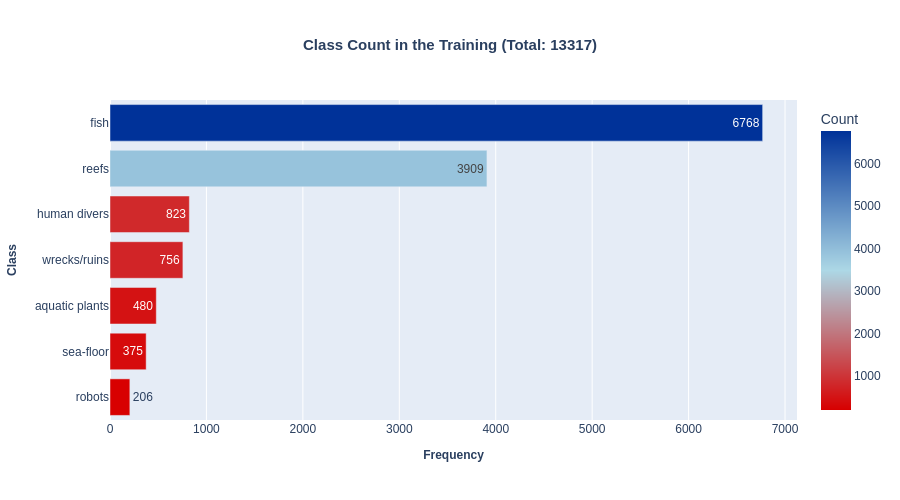

In [21]:
plot_counts(num_train_instances)
plot_counts(num_train_instances, renderer="png")

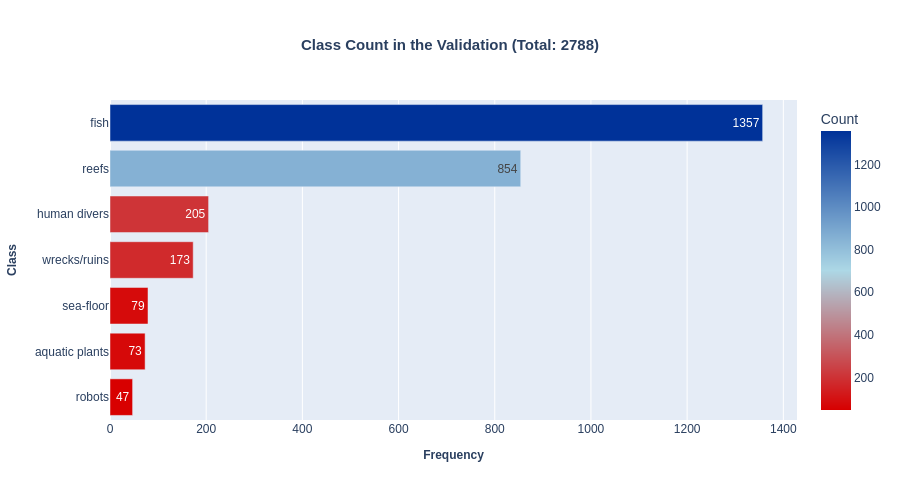

In [22]:
plot_counts(num_val_instances, split="validation")
plot_counts(num_val_instances, split="validation", renderer="png")

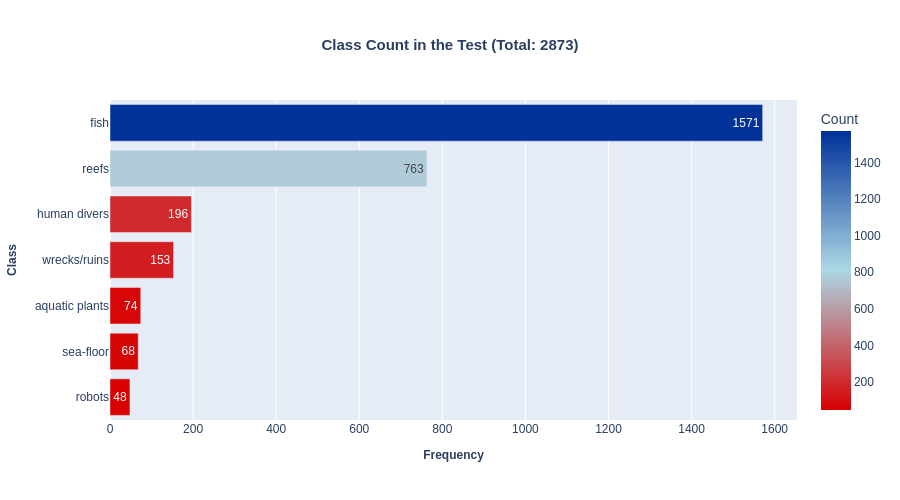

In [23]:
plot_counts(num_test_instances, split="test")
plot_counts(num_test_instances, split="test", renderer="png")

## **Visualization Example**

In [24]:
train_image_paths = sorted(glob(os.path.join(dataset_dir, "train/images/*.jpg")))

In [25]:
id = 2533 #np.random.randint(len(train_image_paths))

image_path = train_image_paths[id]
image = np.array(Image.open(image_path))

with open(image_path.replace("images", "labels").replace(".jpg", ".txt"), "r") as file:
  labels = [row.split() for row in file.readlines()]

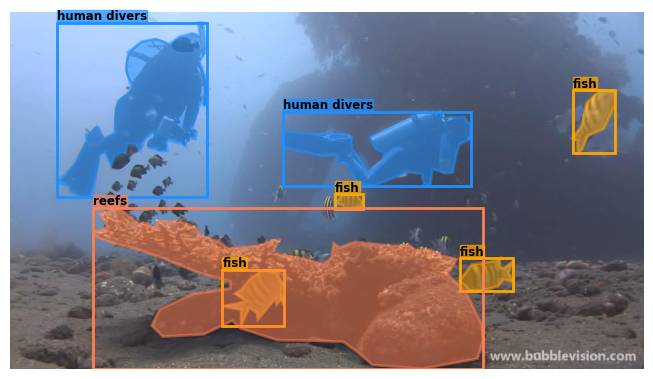

In [26]:
fig, ax = plt.subplots(1, figsize=(7, 7))
shape = image.shape

ax.imshow(image)
for label in labels:
  cls = int(label[0])
  color = class_colors[cls]
  color = tuple(np.array(color) / 255)

  contour = np.array(label[1:]).reshape(-1, 2).astype(np.float32)
  contour[:, 0] *= shape[1]
  contour[:, 1] *= shape[0]
  polygon = patches.Polygon(contour, facecolor=color, edgecolor=color, alpha=0.5, linewidth=2)

  xmin, ymin = contour.min(axis=0)
  xmax, ymax = contour.max(axis=0)
  rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=2, edgecolor=color, facecolor="none")

  ax.add_patch(polygon)
  ax.add_patch(rect)
  ax.text(
      x=xmin, y=ymin, s=f"{class_names[cls]}",
      color="black", fontsize=8.5, fontweight="bold", ha="left", va="bottom",
      bbox={"boxstyle": "square,pad=0", "facecolor": color, "edgecolor": color, "alpha": 0.7}
  )

plt.tight_layout()
ax.axis("off");

The image shows that smaller instances are not labeled, as only the main, larger, and less occluded objects are annotated. This is particularly evident in images with small instances in the USIS10K dataset. This is the only drawback of this dataset, so to improve and make it more robust, it would be necessary to label all present instances.